<a href="https://colab.research.google.com/github/sainaaBL3SSyou/Cryllic2Script/blob/main/Cryllic2HudamScript_no_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf
import unicodedata

# from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
my_data = pd.read_csv('/content/toli_data.csv')
my_data.head()

,TOLGOI_UG,TOLGOI_UG_HUDAM
0,А,ᠠ
1,аравдугаар зүйлийн а,ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ ᠤᠨ ᠡ
2,тавын а анги,ᠲᠠᠪᠤ ᠢᠢᠨ ᠡ ᠠᠨᠭ᠍ᠭᠢ
3,"а үсэг эрдмийн дээж, аяга цай идээний дээж","ᠡ ᠦᠰᠦᠭ ᠡᠷᠳᠡᠮ ᠤᠨ ᠳᠡᠭᠡᠵᠢ, ᠠᠶᠠᠭ᠎ᠠ ᠴᠠᠢ ᠢᠳᠡᠭᠡᠨ ᠦ ᠳᠡ..."
4,"а гэж эрдэм сурдаг, аав гэж хэлд ордог","ᠡ ᠭᠡᠵᠦ ᠡᠷᠳᠡᠮ ᠰᠤᠷᠳᠠᠭ, ᠠᠪᠤ ᠭᠡᠵᠦ ᠬᠡᠯᠡ ᠳᠤ ᠣᠷᠤᠳᠠᠭ"


In [3]:
len(my_data)

135002

#### Давхардсан утгуудыг хасна

In [4]:
my_data = my_data.drop_duplicates()
len(my_data)

125575

#### Хоосон утгуудыг хасна

In [5]:
my_data = my_data.dropna()
len(my_data)

125574

In [6]:
test_data = my_data[-1000:]
my_data = my_data[:-1000]
len(test_data), len(my_data)

(1000, 124574)

In [7]:
test_data.head()

,TOLGOI_UG,TOLGOI_UG_HUDAM
133939,ХИМЭГ,ᠬᠢᠮᠡᠭ
133940,ХИРЧХЭН,ᠬᠢᠷᠢᠴᠢᠬᠡᠨ
133941,ШАГДАЙХ,ᠰᠢᠭᠳᠠᠶᠢᠬᠤ
133942,ШАЛИХАЙ,ᠱᠠᠯᠢᠬᠠᠢ
133943,ШАЛИХАЙРАХ,ᠱᠠᠯᠢᠬᠠᠶᠢᠷᠠᠬᠤ


In [8]:
train_data = my_data[:len(my_data) // 100 * 80]
val_data = my_data[len(train_data):]

In [9]:
f'train data size: {train_data.shape} val data size {val_data.shape}'

'train data size: (99600, 2) val data size (24974, 2)'

#### Сургалтын датаг кирилл болон үндэсний бичгээр ялган листэд оруулах

In [11]:
input_data = train_data.iloc[:, 0].values.tolist()
target_data = train_data.iloc[:, 1].values.tolist()
input_data[:3], target_data[:3]

(['А', 'аравдугаар зүйлийн а', 'тавын а анги'],
 ['ᠠ', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ', 'ᠲᠠᠪᠤ\u202fᠢᠢᠨ ᠡ ᠠᠨᠭ᠍ᠭᠢ'])

In [12]:
target_data_c = target_data.copy()

In [13]:
input_data_c = input_data.copy()

In [14]:
target_data_c[:3], input_data_c[:3]

(['ᠠ', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ', 'ᠲᠠᠪᠤ\u202fᠢᠢᠨ ᠡ ᠠᠨᠭ᠍ᠭᠢ'],
 ['А', 'аравдугаар зүйлийн а', 'тавын а анги'])

#### Бүх кирилл үгсийг жижгээр болгох

In [15]:
input_data_c = list(map(lambda s: s.lower(), input_data_c))

In [16]:
target_data_c[:3], input_data_c[:3]

(['ᠠ', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ', 'ᠲᠠᠪᠤ\u202fᠢᠢᠨ ᠡ ᠠᠨᠭ᠍ᠭᠢ'],
 ['а', 'аравдугаар зүйлийн а', 'тавын а анги'])

#### sos болон eos нарыг өгүүлбэр бүрт нэмнэ.
##### Өгүүлбэрийн цуваа хэзээ эхлэх болон дуусахыг зааж өгөх ёстой. Учир нь модель дараагийн үгсийг таасаар байх ба хэзээ дуусахыг мэдэхгүй

In [17]:
target_data_c = list(map(lambda s: '<sos>' + s + '<eos>', target_data_c))

In [142]:
target_data_c[:10]

['<sos>ᠠ<eos>',
 '<sos>ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ<eos>',
 '<sos>ᠲᠠᠪᠤ\u202fᠢᠢᠨ ᠡ ᠠᠨᠭ᠍ᠭᠢ<eos>',
 '<sos>ᠡ ᠦᠰᠦᠭ ᠡᠷᠳᠡᠮ\u202fᠤᠨ ᠳᠡᠭᠡᠵᠢ, ᠠᠶᠠᠭ\u180eᠠ ᠴᠠᠢ ᠢᠳᠡᠭᠡᠨ\u202fᠦ ᠳᠡᠭᠡᠵᠢ<eos>',
 '<sos>ᠡ ᠭᠡᠵᠦ ᠡᠷᠳᠡᠮ ᠰᠤᠷᠳᠠᠭ, ᠠᠪᠤ ᠭᠡᠵᠦ ᠬᠡᠯᠡ\u202fᠳᠤ ᠣᠷᠤᠳᠠᠭ<eos>',
 '<sos>ᠡ ᠦᠭᠡ\u202fᠢᠢᠨ ᠠᠴᠤᠭ ᠮᠡᠳᠡᠬᠦ ᠦᠭᠡᠢ, ᠠᠷᠪᠠ ᠬᠦᠷᠲᠡᠯ ᠲᠤᠭ᠋\u202fᠠ ᠮᠡᠳᠡᠬᠦ ᠦᠭᠡᠢ<eos>',
 '<sos>ᠠ᠂ ᠮᠠ-ᠦᠭᠡᠢ<eos>',
 '<sos>ᠡ᠂ ᠮᠡ-ᠦᠭᠡᠢ<eos>',
 '<sos>ᠠᠮᠠᠨ\u202fᠳᠤ\u202fᠪᠠᠨ ᠡ-ᠦᠭᠡᠢ, ᠠᠯᠠᠭᠠᠨ\u202fᠳᠠᠭᠠᠨ ᠫᠠᠳ\u202fᠦᠭᠡᠢ<eos>',
 '<sos>ᠠ᠋<eos>']

#### Кирил болон үндэсний бичгийн үгсийг токен болгоно


In [ ]:
input_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    oov_token='<unk>'
)
input_tokenizer.fit_on_texts(input_data_c)
input_tokenizer.get_config()

In [20]:
type(input_tokenizer)

keras.preprocessing.text.Tokenizer

In [ ]:
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    oov_token='<unk>'
)
target_tokenizer.fit_on_texts(target_data_c)
target_tokenizer.get_config()

#### Токенуудаа vector болгоно

In [22]:
#econder layer inputs
train_encoder_inputs = input_tokenizer.texts_to_sequences(input_data_c)

In [23]:
train_encoder_inputs[:3], input_tokenizer.sequences_to_texts(train_encoder_inputs)[:3]

([[2693], [7100, 9417, 2693], [9418, 2693, 181]],
 ['а', 'аравдугаар зүйлийн а', 'тавын а анги'])

#### Доорх функц нь өгүүлбэрийн цуглуулгыг авч, тэдгээрийг векторжуулж, дараа нь тус бүрээс хоёр хуулбарыг буцаана. Эхнийх нь сүүлчийнхээс бусад бүх token-ийг, хоёр дахь нь эхнийхээс бусад бүх токенуудыг агуулна.

In [24]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs] # Өгүүлбэрийн сүүлчийн токенийг хасна
  decoder_targets = [s[1:] for s in seqs] # Өгүүлбэрийн эхний токенийг хасна

  return decoder_inputs, decoder_targets

In [25]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(target_data_c,
                                                                              target_tokenizer)

In [26]:
print(train_decoder_inputs[2], train_decoder_targets[2])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:2]),
      target_tokenizer.sequences_to_texts(train_decoder_targets[:2]))

[2, 8862, 2144, 649] [8862, 2144, 649, 3]
['sos ᠠ', 'sos ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ'] ['ᠠ eos', 'ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ eos']


In [27]:
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

27

In [28]:
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

21

In [29]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [30]:
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[2693    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[  2 729   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[729   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


In [31]:
(target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[1]]))

['sos ᠠᠷᠪᠠᠳᠤᠭᠠᠷ ᠵᠦᠢᠯ\u202fᠤᠨ ᠡ <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>']

In [32]:
def process_dataset(dataset):

  # Оролт болон гаралтын өгөгдлүүдээр хуваана.
  input_data = val_data.iloc[:, 0].values.tolist()
  output_data = val_data.iloc[:, 1].values.tolist()

  # Tag target sentences with <sos> and <eos> tokens.
  tagged_output = list(map(lambda s: '<sos>' + s + '<eos>', output_data))
  # Vectorize encoder source sentences.
  encoder_inputs = input_tokenizer.texts_to_sequences(input_data)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_output,
                                                                    target_tokenizer)

  # Pad all collections.
  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [33]:
# Process validation dataset
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val_data)

In [34]:
(padded_val_decoder_inputs[3])

array([2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [35]:
val_data.head()

,TOLGOI_UG,TOLGOI_UG_HUDAM
106608,хонины нүдэн цэцэг,ᠬᠣᠨᠢᠨ ᠤ ᠨᠢᠳᠦᠨ ᠴᠡᠴᠡᠭ
106609,хонин нүд,ᠬᠣᠨᠢᠨ ᠨᠢᠳᠦ
106610,ХОНЬЖИХ,ᠬᠣᠨᠢᠵᠢᠬᠤ
106611,ХОНЬС,ᠬᠣᠨᠢᠰᠤ
106612,ХОНЬЧ,ᠬᠣᠨᠢᠴᠢ


In [36]:
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 32
epochs = 30

In [37]:
source_vocab_size = len(input_tokenizer.word_index) + 1
print(source_vocab_size)

54026


In [38]:
target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

64368


#### Өмнөх үүсгэсэн модел нь 2 оролт авна
1. Encoder нь кирилл оролтыг хүлээн авч decoder-ийн /decoder input/ оролт блолгон хувиргана.
2. Decoder нь мөн Teacher Forcing-д зориулж кирилл оролтыг хүлээн авна.

Ийм учраас Keras Sequential API-г ашиглахгүй.
Моделийн давхаргуудыг график байдлаар харахын тулд Functional API ашиглна.
#### https://keras.io/api/models/sequential/
#### https://www.tensorflow.org/guide/keras/functional/

Давхарга бүр нь график дахь зангилаатай адил юм. Бид нэг давхаргын гаралтыг нөгөө рүү дамжуулах бүрт энэ нь хоёр зангилааны хооронд холбоос үүсгэж, өгөгдөл дамжуулах боломжийг олгодог. Сургалтын загварыг бүхэлд нь бүтээсний дараа бид үүнийг илүү тодорхой болгохын тулд дүрслэн харуулах болно.

references
###### https://keras.io/api/layers/core_layers/embedding/
###### https://keras.io/api/layers/core_layers/input/
###### https://keras.io/api/layers/recurrent_layers/lstm/

### Encoder LSTM without attention

In [39]:
#input layer
encoder_inputs = layers.Input(shape=[None], name='encoder_inputs')

# embedding layer
encoder_embeddings = layers.Embedding(source_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='encoder_embeddings')

# Оролтын давхаргыг embedding давхаргатай холбож байна.
# Оролтын давхаргаас гарсан утгууд embedding давхаргаруу орох дарааллаар явна.
encoder_embedding_output = encoder_embeddings(encoder_inputs)


# We're not using any kind of attention mechanism in this model, so setting only
# return_state to True is enough. return_sequences remains False.
encoder_lstm = layers.LSTM(hidden_dim,
                           return_state=True,
                           dropout=default_dropout,
                           name='encoder_lstm')

# Passing the embedding layer output to the LSTM layer creates another link.
# IMPORTANT: The LSTM always returns three values. When return_sequences is
# False, encoder_outputs and state_h are the SAME. When return_sequences is
# True, encoder_outputs contains the encoder hidden states from each time step.
#
# Side note: we won't be using encoder_outputs here so that variable can be
# replaced with a _ if preferred.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)

# The final hidden and cell/context states from the encoder will be the the
# initial states for the decoder.
encoder_states = (state_h, state_c)

### Decoder LSTM without attention

In [40]:
decoder_inputs = layers.Input(shape=[None], name='decoder_inputs')


decoder_embeddings = layers.Embedding(target_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='decoder_embeddings')


decoder_embedding_output = decoder_embeddings(decoder_inputs)

# Return sequences set to True.
decoder_lstm = layers.LSTM(hidden_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=default_dropout,
                           name='decoder_lstm')


# Set the decoder's initial state to the encoder's final output states. Since
# return_sequences is set to True, decoder_outputs is going to be a collection of
# the decoder's hidden state at each timestep. Also note that since we don't need
# the decoder's final hidden output and cell states, those are just set to _.
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

# Have a softmax layer in the end to create a probability distribution for the output word.
decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

# The probability distribution for the output word.
y_proba = decoder_dense(decoder_outputs)


In [41]:
# Note how the model is taking two inputs in an array.
model = tf.keras.Model([encoder_inputs, decoder_inputs], y_proba, name='cyr_hudam_seq2seq_nmt_no_attention')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics='sparse_categorical_accuracy')
model.summary()

Model: "cyr_hudam_seq2seq_nmt_no_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embeddings (Embedding)  (None, None, 128)   6915328     ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embeddings (Embedding)  (None, None, 128)   8239104     ['decoder_inputs[0][0]']         
                                                                 

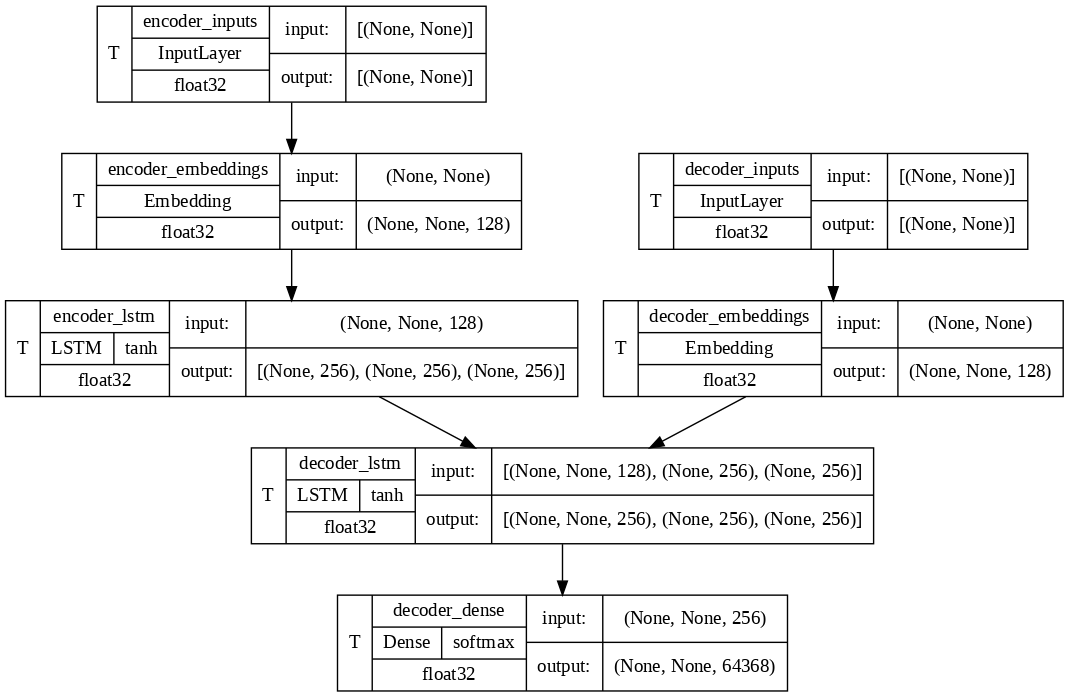

In [42]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=1,
    show_dtype=1,
    show_layer_names=1,
    rankdir='RB',
    expand_nested=1,
    dpi=100,
    layer_range=None,
    show_layer_activations=1,
    show_trainable=1
)

In [43]:

filepath = r"/content/"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

In [44]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)

In [45]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
                     callbacks=[cp_callback, es_callback])

Epoch 1/30
3113/3113 [==============================] - ETA: 0s - loss: 6.4568 - sparse_categorical_accuracy: 0.3589
Epoch 1: saving model to /content/
3113/3113 [==============================] - 384s 118ms/step - loss: 6.4568 - sparse_categorical_accuracy: 0.3589 - val_loss: 6.3867 - val_sparse_categorical_accuracy: 0.3754
Epoch 2/30
3113/3113 [==============================] - ETA: 0s - loss: 5.3139 - sparse_categorical_accuracy: 0.3934
Epoch 2: saving model to /content/
3113/3113 [==============================] - 318s 102ms/step - loss: 5.3139 - sparse_categorical_accuracy: 0.3934 - val_loss: 6.2993 - val_sparse_categorical_accuracy: 0.4171
Epoch 3/30
3113/3113 [==============================] - ETA: 0s - loss: 4.2736 - sparse_categorical_accuracy: 0.4596
Epoch 3: saving model to /content/
3113/3113 [==============================] - 314s 101ms/step - loss: 4.2736 - sparse_categorical_accuracy: 0.4596 - val_loss: 6.4369 - val_sparse_categorical_accuracy: 0.4638
Epoch 4/30
3113/311

In [46]:
history

In [47]:
model

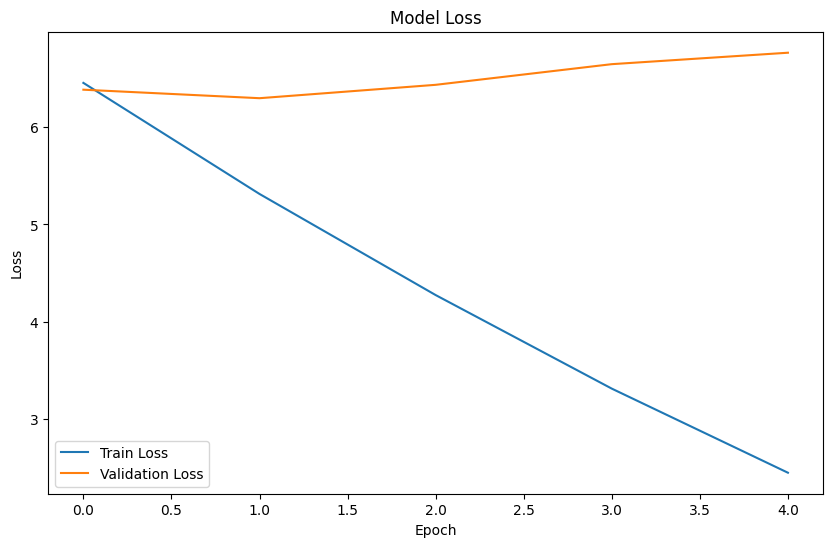

In [48]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test

Тестийн өгөгдлийг token болгож байна

In [87]:
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(test_data)

In [86]:
test_data.head(3),test_encoder[:3]

(       TOLGOI_UG TOLGOI_UG_HUDAM
 133939     ХИМЭГ          ᠬᠢᠮᠡᠭ 
 133940   ХИРЧХЭН      ᠬᠢᠷᠢᠴᠢᠬᠡᠨ 
 133941   ШАГДАЙХ       ᠰᠢᠭᠳᠠᠶᠢᠬᠤ,
 array([[ 836, 2452,   90,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [ 615,   41,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]], dtype=int32))

Моделоо үнэлж байна

In [89]:
score = model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

781/781 [==============================] - 47s 60ms/step - loss: 6.7672 - sparse_categorical_accuracy: 0.5147


In [93]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 6.767200469970703
Test Accuracy: 0.514747679233551


моделийн давхаргууд

In [94]:
[layer.name for layer in model.layers]

['encoder_inputs',
 'decoder_inputs',
 'encoder_embeddings',
 'decoder_embeddings',
 'encoder_lstm',
 'decoder_lstm',
 'decoder_dense']

моделоо хадгалах

In [66]:
model.save('translate_no_attention_model.keras')

In [69]:
def translate_without_attention(sentence: str,
                                source_tokenizer, encoder,
                                target_tokenizer, decoder,
                                max_translated_len = 30):

  # Vectorize the source sentence and run it through the encoder.
  input_seq = source_tokenizer.texts_to_sequences([sentence])

  # Get the tokenized sentence to see if there are any unknown tokens.
  tokenized_sentence = source_tokenizer.sequences_to_texts(input_seq)

  states = encoder.predict(input_seq)

  current_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < max_translated_len:

    # Set the next input word for the decoder.
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_tokenizer.word_index[current_word]

    # Determine the next word.
    target_y_proba, h, c = decoder.predict([target_seq] + states)
    target_token_index = np.argmax(target_y_proba[0, -1, :])
    current_word = target_tokenizer.index_word[target_token_index]

    if (current_word == '<eos>'):
      break

    decoded_sentence.append(current_word)
    states = [h, c]

  return tokenized_sentence[0], ' '.join(decoded_sentence)


In [135]:
def translate_sentences(sentences, translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for s in range(len(test_data.values.tolist())):
    source = test_data.iloc[:, 0].values.tolist()
    target = test_data.iloc[:, 1].values.tolist()
    source = list(map(lambda s: '<sos>' + s + '<eos>', source))
    target = list(map(lambda s: '<sos>' + s + '<eos>', target))
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

In [102]:
encoder_inputs = model.get_layer('encoder_inputs').input

encoder_embedding_layer = model.get_layer('encoder_embeddings')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('encoder_lstm')

_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)

encoder_states = [encoder_state_h, encoder_state_c]

# Our stand-alone encoder model. encoder_inputs is the input to the encoder,
# and encoder_states is the expected output.
encoder_model_no_attention = tf.keras.Model(encoder_inputs, encoder_states)

In [103]:
decoder_inputs = model.get_layer('decoder_inputs').input

decoder_embedding_layer = model.get_layer('decoder_embeddings')
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

# Inputs to represent the decoder's LSTM hidden and cell states. We'll populate
# these manually using the encoder's output for the initial state.
decoder_input_state_h = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_h')
decoder_input_state_c = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_c')
decoder_input_states = [decoder_input_state_h, decoder_input_state_c]

decoder_lstm = model.get_layer('decoder_lstm')

decoder_sequence_outputs, decoder_output_state_h, decoder_output_state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_input_states
)

# Update hidden and cell states for the next time step.
decoder_output_states = [decoder_output_state_h, decoder_output_state_c]

decoder_dense = model.get_layer('decoder_dense')
y_proba = decoder_dense(decoder_sequence_outputs)

decoder_model_no_attention = tf.keras.Model(
    [decoder_inputs] + decoder_input_states,
    [y_proba] + decoder_output_states
)

In [137]:
translations_no_attention = pd.DataFrame(translate_sentences(test_data, translate_without_attention,
                                                             input_tokenizer, encoder_model_no_attention,
                                                             target_tokenizer, decoder_model_no_attention))
translations_no_attention

1/1 [==============================] - 0s 50ms/step


KeyError: ignored

In [1]:
model.predict([padded_test_encoder_inputs, padded_test_decoder_inputs])

NameError: ignored